# Caderno 10(b) - Calcula métricas considerando os resultados de pesquisa em um BM25 com expansão de documentos usando sinônimos gerados pelo GPT 4o e pelo Llama para as palavras mais relevantes encontradas no enunciados

Nota: Esse caderno é praticamente igual ao caderno 10(a) referente ao GPT-3.5. O que muda é a origem do arquivo de sinônimos e o arquivo de saída gerado.

In [1]:
# Se True, refaz a indexação. Se False, tenta recuperar o
# índice do arquivo indice_js_enunciado_e_excerto.pickle.
# É necessário que esse arquivo exista.
REINDEXAR_SINONIMOS_ENUNCIADO_EXCERTO_GPT = False

PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/10_metricas_bm25_com_sinonimos_enunciado_gpt_llama/'
NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto_e_sinonimos_enunciado_gpt4o.pickle'

# 1. Carrega base de dados

Carrega a lista de documentos para indexar, as queries para testar e o qrels.

In [2]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

Carrega a expansão das queries gerada no caderno anterior:

In [3]:
import pickle

PASTA_CADERNO_REESCRITA_GPT_LLAMA = f'{PASTA_DADOS}outputs/9_sinonimos_enunciado_gpt_llama/'
NOME_ARQUIVO_RESULTADO_GPT = f'{PASTA_CADERNO_REESCRITA_GPT_LLAMA}sinonimos_enunciados_gpt4o.pickle'

with open(NOME_ARQUIVO_RESULTADO_GPT, 'rb') as f:
    enunciado_gpt_por_doc = pickle.load(f)

Insere a reescrita no dataframe de documentos.

In [4]:
docs['ENUNCIADO_GPT'] = docs['KEY'].map(lambda key: enunciado_gpt_por_doc[key])

# 2. Instancia um BM25 e indexa os campos ENUNCIADO e EXCERTO e as queries expandidas

In [5]:
from bm25 import IndiceInvertido, BM25, tokenizador_pt_remove_html

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [6]:
import os

# Vamos criar um índice invertido e indexar o enunciado, excerto e o enunciado gerado com o GPT
iidx_expansao_gpt = IndiceInvertido(tokenizador_pt_remove_html)

if REINDEXAR_SINONIMOS_ENUNCIADO_EXCERTO_GPT or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT):
    # Se for indexar a primeira vez:
    # Demora cerca de 40 minutos para indexar
    iidx_expansao_gpt.adiciona_dataframe(docs, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['EXCERTO'] + ' ' + row['ENUNCIADO_GPT']))
    iidx_expansao_gpt.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT)
else:
    # Se quiser recuperar de um arquivo:
    iidx_expansao_gpt.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_GPT)

100%|██████████████████████████████████████████████████████████████████████████| 16045/16045 [1:09:21<00:00,  3.86it/s]


In [7]:
print(iidx_expansao_gpt.get_tamanho_medio_docs())

491.9407291991275


In [8]:
buscador_gpt = BM25(iidx_expansao_gpt, k1=0.82, b=0.68, bias_idf=1)

# 3. Faz as pesquisas e salva os resultados

In [9]:
col_resultado_query_key_gpt=[]
col_resultado_doc_key_gpt=[]
col_resultado_rank_gpt=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    
    resultados_gpt = buscador_gpt.pesquisar(query_text)

    # GPT
    primeiros_50_docs_gpt = [tupla_key_score[0] for tupla_key_score in resultados_gpt[:50]]
    queries_keys_gpt = [query_key] * len(primeiros_50_docs_gpt)
    ranking_gpt = list(range(1, len(primeiros_50_docs_gpt)+1))

    col_resultado_query_key_gpt.extend(queries_keys_gpt)
    col_resultado_doc_key_gpt.extend(primeiros_50_docs_gpt)
    col_resultado_rank_gpt.extend(ranking_gpt)

df_resultados_gpt = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key_gpt,
    "DOC_KEY": col_resultado_doc_key_gpt,
    "RANK": col_resultado_rank_gpt,
})

In [10]:
from metricas import metricas

df_metricas_gpt = metricas(df_resultados_gpt, qrels, aproximacao_trec_eval=True)

## 3.1 Resultados GPT 4o

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.276000,0.258000,0.217000,0.129600,0.110746,0.214069,0.360048,0.532838,0.551667,0.576381,0.578048,0.581579,0.299506,0.296885,0.371415,0.453962
std,14.57738,0.264621,0.184158,0.129996,0.057745,0.102133,0.163423,0.231071,0.269611,0.443167,0.414161,0.411956,0.407015,0.270468,0.221653,0.232722,0.230011
min,1.00000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.024390,0.000000,0.000000,0.000000,0.062415
25%,13.25000,0.000000,0.100000,0.112500,0.080000,0.000000,0.076923,0.178571,0.291209,0.000000,0.166667,0.166667,0.166667,0.000000,0.098746,0.223336,0.269473
50%,25.50000,0.200000,0.300000,0.225000,0.120000,0.083333,0.200000,0.363636,0.541958,0.500000,0.500000,0.500000,0.500000,0.303983,0.249085,0.350988,0.454974
75%,37.75000,0.400000,0.400000,0.300000,0.180000,0.181818,0.325000,0.461538,0.792308,1.000000,1.000000,1.000000,1.000000,0.481513,0.463687,0.538774,0.651090
max,50.00000,1.000000,0.700000,0.500000,0.220000,0.384615,0.600000,0.818182,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.842749,0.841333,0.841333


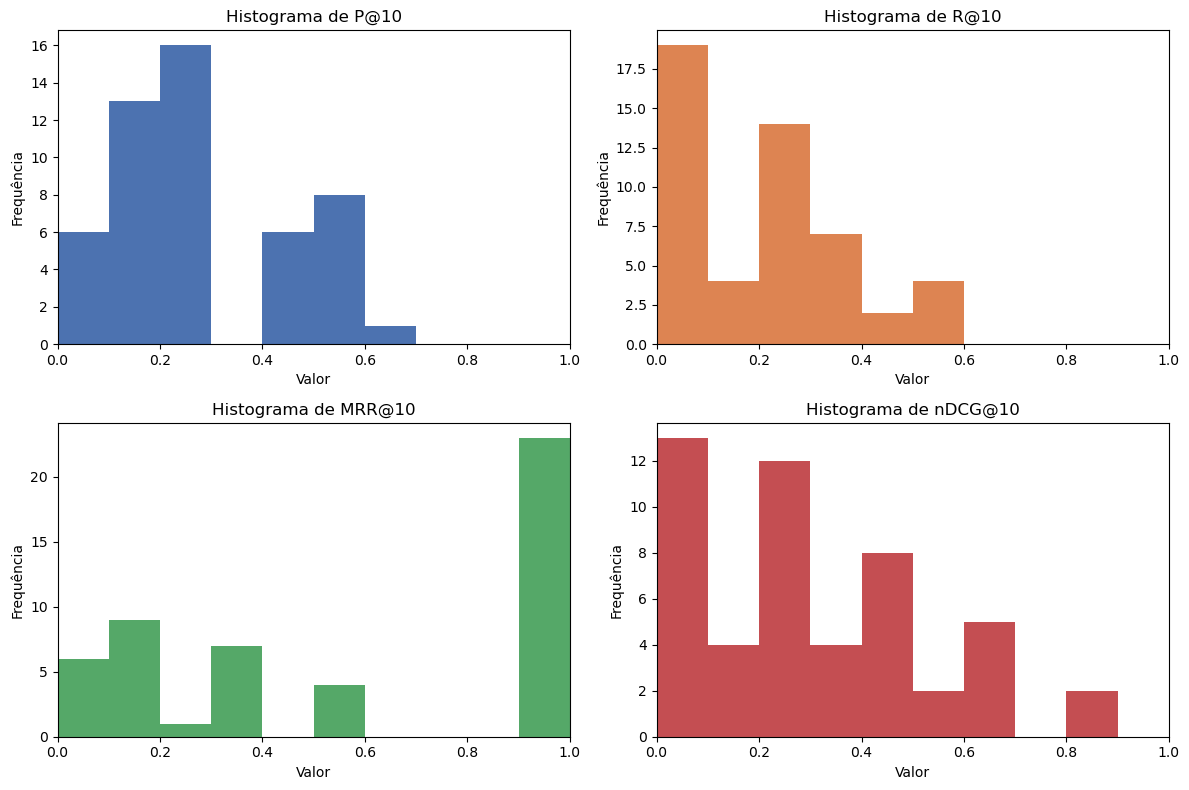

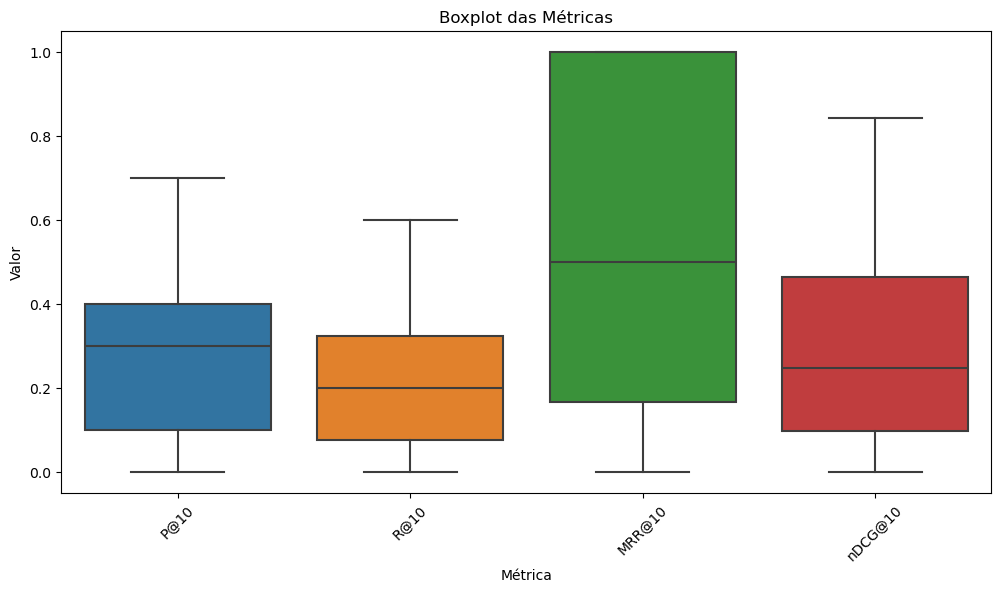

In [12]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries, GPT:
display(df_metricas_gpt[0:50].describe())
histograma_metricas(df_metricas_gpt[0:50])
boxplot_metricas(df_metricas_gpt[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.544000,0.39400,0.270000,0.143200,0.226467,0.331843,0.452000,0.596101,0.898000,0.904190,0.904190,0.904190,0.617289,0.540435,0.579540,0.641821
std,14.57738,0.277128,0.20345,0.128968,0.049216,0.118487,0.186217,0.235487,0.221007,0.267635,0.247443,0.247443,0.247443,0.243308,0.195410,0.198746,0.176550
min,51.00000,0.000000,0.10000,0.050000,0.020000,0.000000,0.071429,0.076923,0.083333,0.000000,0.142857,0.142857,0.142857,0.000000,0.083803,0.140989,0.140989
25%,63.25000,0.400000,0.20000,0.150000,0.105000,0.153846,0.224359,0.275974,0.461538,1.000000,1.000000,1.000000,1.000000,0.481475,0.404203,0.445534,0.572517
50%,75.50000,0.600000,0.40000,0.275000,0.160000,0.226496,0.307692,0.428571,0.607692,1.000000,1.000000,1.000000,1.000000,0.654809,0.584737,0.602169,0.652860
75%,87.75000,0.800000,0.50000,0.350000,0.180000,0.326923,0.448052,0.583333,0.750000,1.000000,1.000000,1.000000,1.000000,0.773065,0.678119,0.664581,0.752779
max,100.00000,1.000000,0.80000,0.500000,0.200000,0.454545,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.906178,0.930222,0.953210


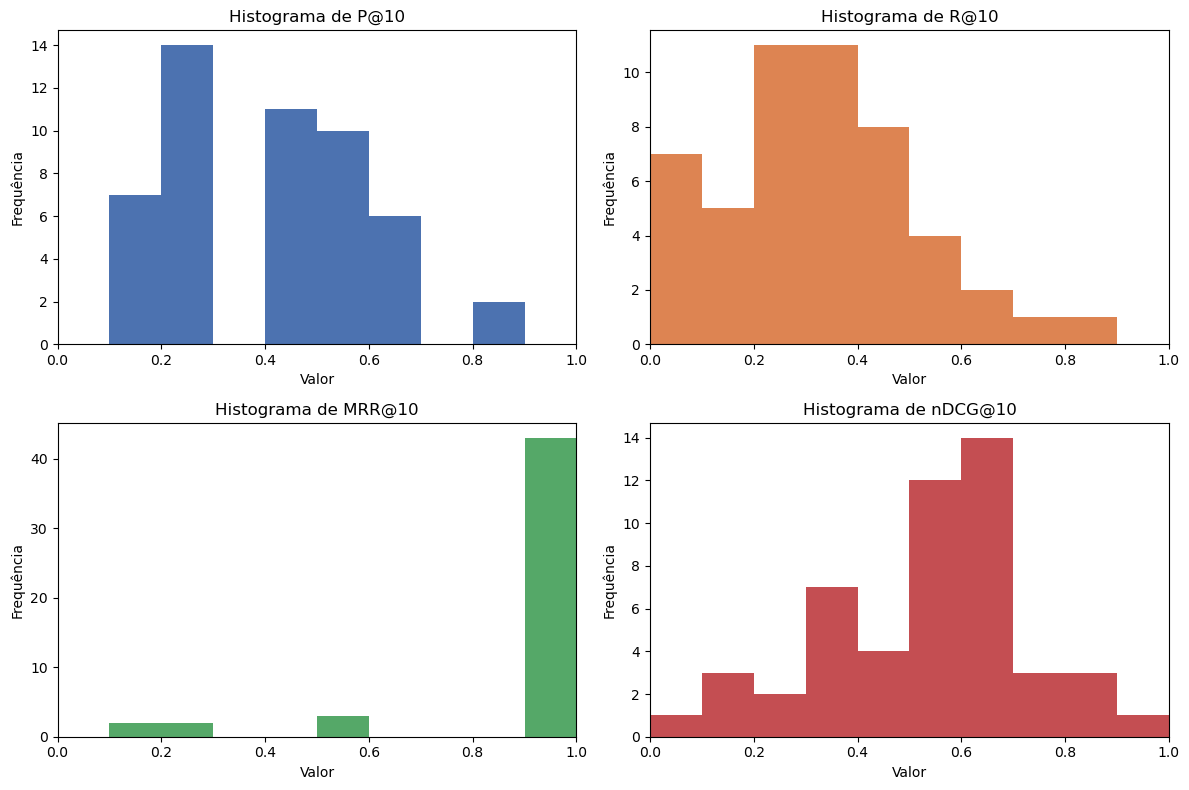

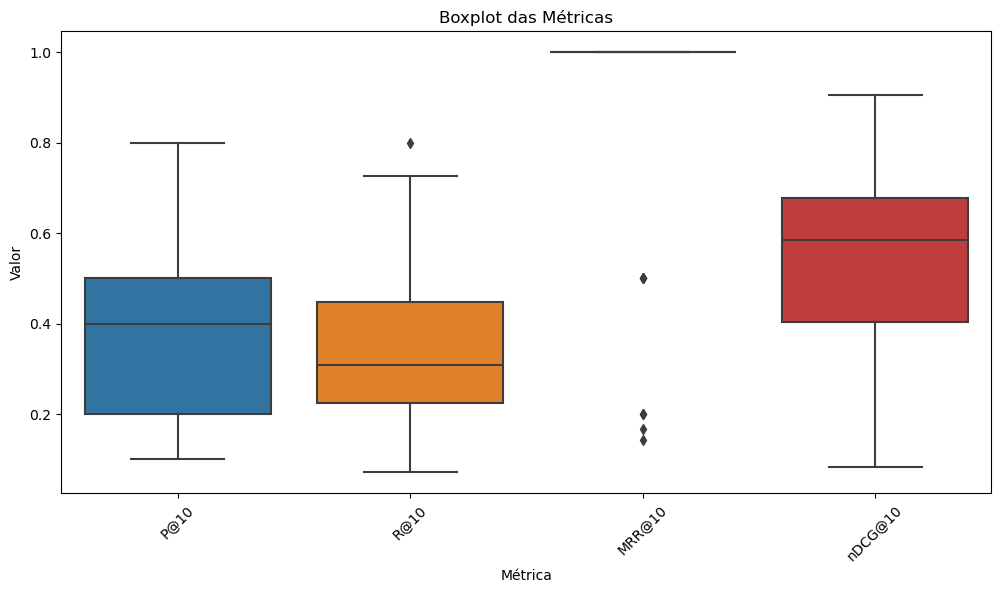

In [13]:
# Resultados para o segundo grupo de queries, GPT:
display(df_metricas_gpt[50:100].describe())
histograma_metricas(df_metricas_gpt[50:100])
boxplot_metricas(df_metricas_gpt[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.528000,0.388000,0.267000,0.137600,0.237407,0.345439,0.474165,0.606645,0.923000,0.923000,0.923000,0.923000,0.611551,0.534175,0.585506,0.641096
std,14.57738,0.254783,0.189133,0.123143,0.052316,0.123555,0.169092,0.220256,0.230596,0.216467,0.216467,0.216467,0.216467,0.220233,0.182221,0.188231,0.173038
min,101.00000,0.200000,0.100000,0.050000,0.020000,0.066667,0.066667,0.066667,0.100000,0.200000,0.200000,0.200000,0.200000,0.087470,0.128950,0.231365,0.273531
25%,113.25000,0.400000,0.200000,0.200000,0.100000,0.153846,0.207692,0.314103,0.456294,1.000000,1.000000,1.000000,1.000000,0.478238,0.416235,0.452464,0.498397
50%,125.50000,0.600000,0.400000,0.275000,0.140000,0.214286,0.333333,0.500000,0.636364,1.000000,1.000000,1.000000,1.000000,0.602266,0.548223,0.590825,0.659858
75%,137.75000,0.800000,0.500000,0.350000,0.180000,0.356061,0.459790,0.611538,0.750000,1.000000,1.000000,1.000000,1.000000,0.796432,0.677870,0.760206,0.773186
max,150.00000,1.000000,0.800000,0.500000,0.220000,0.500000,0.727273,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.872048,0.937898,0.937898


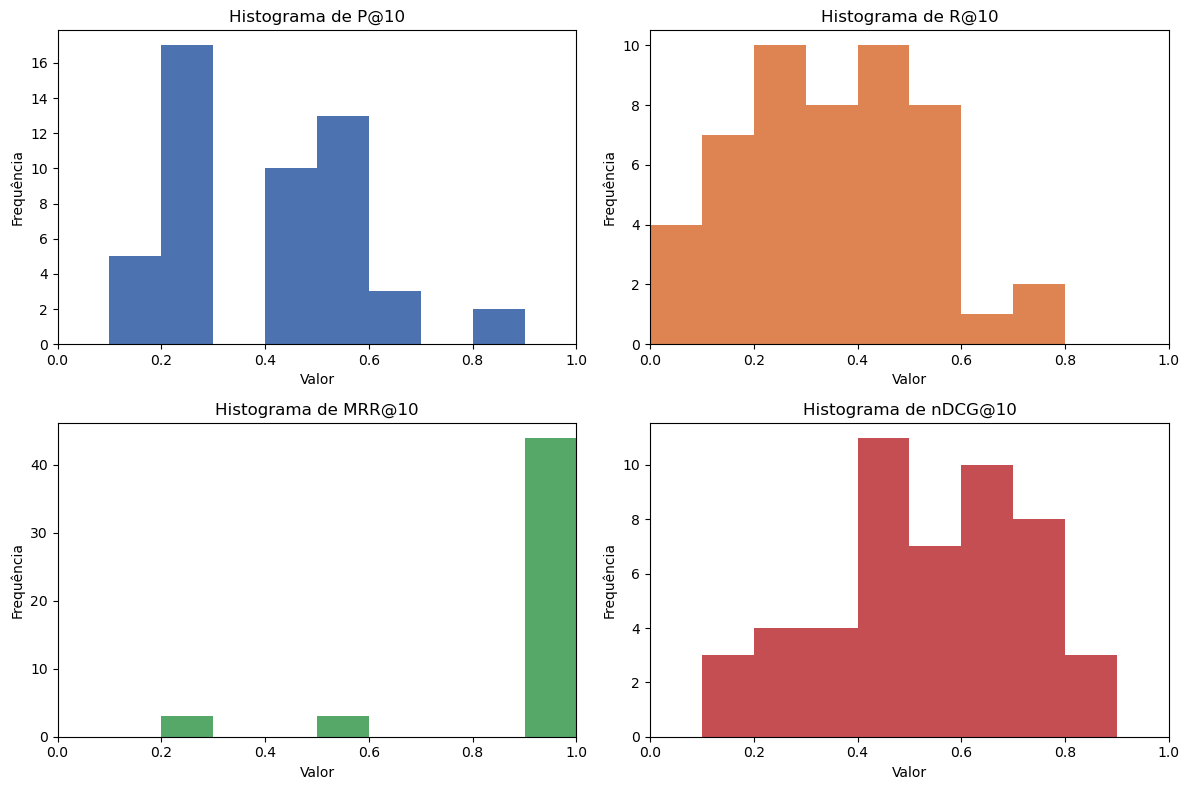

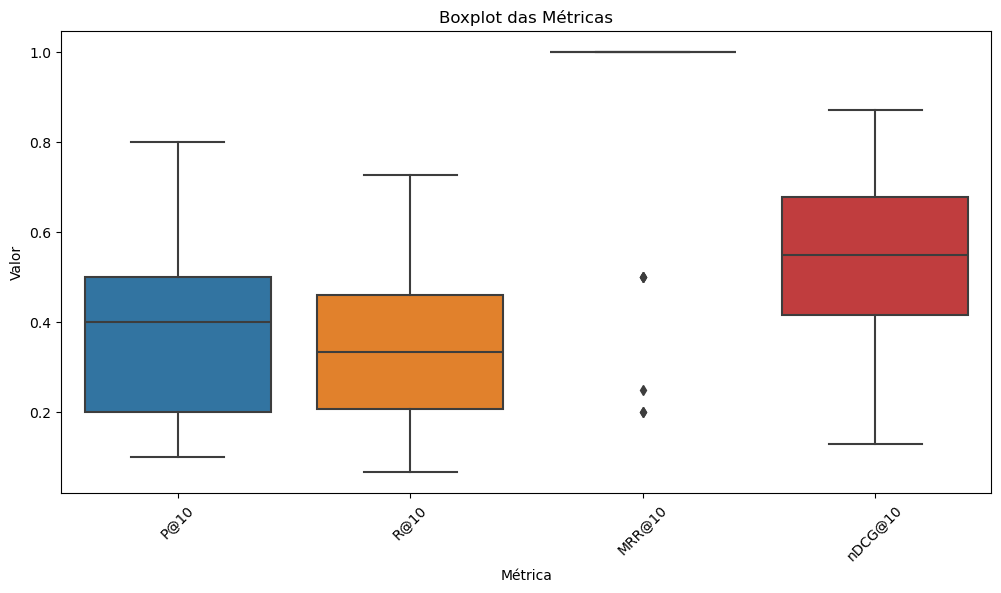

In [14]:
# Resultados para o terceiro grupo de queries, GPT:
display(df_metricas_gpt[100:150].describe())
histograma_metricas(df_metricas_gpt[100:150])
boxplot_metricas(df_metricas_gpt[100:150])